# ASKERİ UÇAKLARIN TESPİTİ

Bu projede Görüntü Sınıflandırma için Transfer Learning kullanacağız. Ancak önceki projelerden farklı olarak:
1. Bu projede hem eğitim hem de test için kendi özel veri setimizi kullanacağız.
2. VGG16 CNN A lgoritması ile önceden eğitilmiş karmaşık derin öğrenme modelini kullanacağız
3.Veri setimi MTARSI den aldım.

<IMG src="a10.jpg" width="200" height="200">

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img # Görüntü işlemleri için
from tensorflow.keras.models import Sequential # Bunlar, yeni modelimizi oluşturmak için.Katman ile bir model katman oluşturmanıza izin verir.
from tensorflow.keras.layers import Dense # unlar, yeni modelimizi oluşturmak için gerekli.
from tensorflow.keras.applications.vgg16 import VGG16  # Bu projede kullanılacak Transfer Learning modeli.
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from PIL import Image # Python Görüntüleme Kitaplığı - Şunlar gibi işlemler için: Görüntü açma, görüntüyü yeniden boyutlandırma, vb.
import matplotlib.pyplot as plt#verileri görselleştirmek için.
import numpy as np

In [2]:
# Öncelikle train ve test image path tanımlayacağız...
train_files_path = "airplanedataset/Train/"
test_files_path = "airplanedataset/Test/"

# Veri kümemizden herhangi bir uçak görüntüsünü yüklenmesi;
img = load_img(test_files_path + "B-52/3-1.jpg")


In [3]:
#Boyut sorgulama;
print(img_to_array(img).shape)

(230, 266, 3)


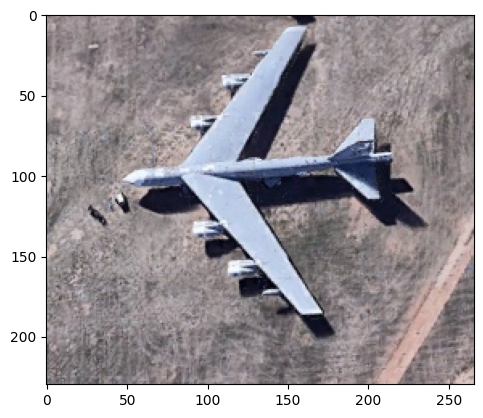

In [4]:
# Uçağı veri setimiz içinden doğru görüp görmediğimize bakmak için;
plt.imshow(img)
plt.show()

In [5]:
# Uçak görüntülerinin bulunduğu dizinlerden tren ve test veri setlerimizi oluşturalım.
train_data = ImageDataGenerator().flow_from_directory(train_files_path,target_size = (224,224))
test_data = ImageDataGenerator().flow_from_directory(test_files_path,target_size = (224,224))
#vgg boyutları 224,224 olduğu için resimlerin boyutlarını ona göre çevirdik.
#flow_from_directory = veri setimizdeki her bir class içindeki resimleri belirli boyutlara çeviriyor.


Found 3271 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


In [6]:
#Veri setimizde ki uçak tiplerini belirtelim;
numberOfAirplaneTypes = 8  

### MODEL OLUŞTURMA
VGG16 modelinin hem eğitim hem de test için kendi girdileri vardır, bu nedenle girdileri değiştirmeliyiz..Orijinal VGG16 modeli, özel olarak uçak görüntüleri olmayan 1000 görüntü kategorisine sahip ImageNet veri kümesi #(yaklaşık 22.000 kategoriye ait 15 milyondan fazla etiketli yüksek çözünürlüklü görüntüden oluşan bir veri kümesidir) 
için tasarlanmıştır. Bu, veri setimizde uçak görüntülerinin sınıflandırılması için yeni bir model oluşturacağımız ve bu yeni 
modelde VGG16 nın önceden eğitilmiş katmanlarını kullanacağız.
VGG16 nın 16 tane önceden tasatlanmış layerini kullanacağımız için modelimizin içinde aktarıyoruz. 

In [7]:
# Modeli oluşturmak için
vgg = VGG16()

In [8]:
#VGG16 nın 16 tane önceden tasatlanmış layerini kullanacağımız için modelimizin içinde aktarıyoruz.
vgg_layers = vgg.layers
print(vgg_layers)

[<keras.engine.input_layer.InputLayer object at 0x0000019CEE4FDE10>, <keras.layers.convolutional.conv2d.Conv2D object at 0x0000019CEE4FE650>, <keras.layers.convolutional.conv2d.Conv2D object at 0x0000019CEE4D5A50>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000019CEE4FECB0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x0000019CEE4FEFE0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x0000019CF06F16F0>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000019CF06F2680>, <keras.layers.convolutional.conv2d.Conv2D object at 0x0000019CF06F1ED0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x0000019CF06F3670>, <keras.layers.convolutional.conv2d.Conv2D object at 0x0000019CF06F3700>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000019CF0704CD0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x0000019CF06F2170>, <keras.layers.convolutional.conv2d.Conv2D object at 0x0000019CF0706620>, <keras.layers.convolutional.conv2d

In [9]:
# Yeni bir Sequential modeli oluşturacağım ve Vgg16 modelindeki tüm katmanları yeni modelime ekleyeceğim.
# çıkış katmanı olan output layeri kaldırıyorum, çünkü modelime kendi  output layerimi oluşturacağım.
# giriş sınıfları (askeri uçaklarımın türleri)...
# Bunun için vggmodel_layersize_tobe_used = len(vgg_layers) - 1 tanımlıyorum 
#eksi 1, son katmanı -output layeri atladığım anlamına gelir
vggmodel_layersize_tobe_used = len(vgg_layers) - 1

model = Sequential()
for i in range(vggmodel_layersize_tobe_used):
    model.add(vgg_layers[i])
# Bu döngüyü kurarak kendi layerlerime output layeri çıkarılmış vgg layerlerini döndürerek ekliyorum.
#output layeri almamamın nedeni kendi 1000 tane fotoğraf kategorilerinin modelime eklenmesini istemiyorum.


In [41]:
#VGG16 nın complex kamtmanlarını tekrar train etmemesi için false yaptım eğer yapnmasaydım çok uzun sürebilirdi.
for layers in model.layers:
    layers.trainable = False

# VGG16'nın orijinal output layerini kaldırdığım için, yeni output layerimi  modelime eklemeliyim.(Dense)
model.add(Dense(numberOfAirplaneTypes, activation="softmax"))


print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [11]:
# Modelimi dizayn ettikten sonra compile ediyorum.
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

In [12]:
#modelimi train ediyorum.
batch_size = 4 

model.fit_generator(train_data,
                           steps_per_epoch=400//batch_size,
                           epochs= 3, 
                           validation_data=test_data,
                           validation_steps= 200//batch_size)

C:\Users\emire\AppData\Local\Temp\ipykernel_11788\3198648381.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_data,


Epoch 1/3
100/100 [==============================] - 213s 2s/step - loss: 1.1300 - accuracy: 0.6694 - val_loss: 0.6921 - val_accuracy: 0.7812
Epoch 2/3
100/100 [==============================] - 208s 2s/step - loss: 0.4003 - accuracy: 0.8595
Epoch 3/3
100/100 [==============================] - 208s 2s/step - loss: 0.2618 - accuracy: 0.9093


 #### Lütfen doğruluğun bir grup eğitim verisinin doğruluğu olduğunu ve val_accuracy'nin bir grup test verisinin doğruluğu olduğunu unutmayın. Bu nedenle, modelimizin test veri kümesiyle (modelimizin daha önce görmediği görüntüler) %78 oranında iyi bir doğrulama doğruluğuna sahibiz.

### Şimdi yeni Askeri Uçak Tanıma modelimizi kendi gözlerinizle test etme zamanı

In [28]:
#Rsim yükleme.
img = Image.open("f-22s.jpg").resize((224,224))

In [29]:
# işlenmesi için array e çevirmemiz lazım
img = np.array(img)

In [30]:
# resmimizin oyutları
img.shape

(224, 224, 3)

In [31]:
#boyutu
print(img.ndim)

3


In [32]:
# Dizimize ekstra bir boyut eklemeliyiz ki yeniden şekillendirelim.
img = img.reshape(-1,224,224,3)   
# reshape(-1,..) ile 1 ekstra boyut ekliyorum.
# Bunu yapıyorum çünkü modelim 4 boyutlu dizi gerektiriyor.

In [33]:
#tekrardan bakıyoruz.
print(img.shape)
print(img.ndim)

(1, 224, 224, 3)
4


In [34]:
# Modelimin preprocess_input'unu kullanarak giriş piksellerini -1 ile 1 arasında ölçeklendireceğim
# VGG16 modeli bunu gerektirir..
img = preprocess_input(img)   

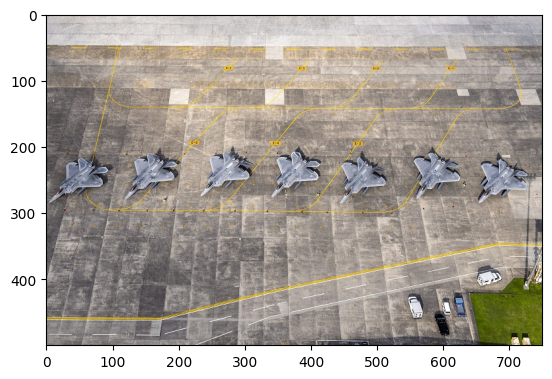

In [35]:
# Uçağın resmini göremke için.
img_for_display = load_img("f-22s.jpg")
plt.imshow(img_for_display)
plt.show()

###  prediction etme:

In [36]:
preds = model.predict(img)


1/1 [==============================] - 0s 115ms/step


In [37]:
# Let's see contents of prediction array.. 
preds

array([[3.0574211e-01, 2.9185159e-07, 2.7579959e-05, 5.3274129e-05,
        6.7771875e-06, 1.4426265e-05, 6.9415545e-01, 1.7220302e-12]],
      dtype=float32)

These are the possibilities of each output (one-hot encoding)

Lütfen Softmax konsepti:

Örneğin, üç sınıf etiketi 0, 1 ve 2 olarak kodlanmış tamsayı olacaktır. Daha sonra aşağıdaki gibi vektörlere kodlanmıştır:

Sınıf 0: [1, 0, 0]
Sınıf 1: [0, 1, 0]
Sınıf 2: [0, 0, 1]
Buna tek sıcak kodlama denir.

Bizim durumumuzda:
A-10 Yıldırım: [1,0,0,0,0]
Boeing B-52: [0,1,0,0,0]
....
bunun gibi..

Örneğin, tamsayı kodlu sınıf 1 bekleniyorsa, hedef vektör şöyle olurdu:
[0, 1, 0]

Softmax çıktısı, en fazla ağırlığı sınıf 1'e ve diğer sınıflara daha az ağırlık veren aşağıdaki gibi görünebilir.

Örneğin, yukarıdaki 3 çıktı örneğinde, bunun gibi bir softmax çıktımız olsaydı:
[0,09003057 0,67524096 0,23472847]

O zaman en yüksek olasılık sonucunun 0.67524096 olduğunu söyleyebiliriz ki bu da Sınıf 1'dir.
Dizini sadece numpy'nin argmax işlevini kullanarak bulabilirim:

sınıf tamsayı = argmax([0.09003057 0.67524096 0.23472847])

In [38]:
image_classes = ["A-10 Thunderbolt","B-1","Boeing B-52","C-17","C-135","Boeing E-3 Sentry","F-22 Raptor","KC-10 Extender"]

result = np.argmax(preds[0])
print(image_classes[result]) 

F-22 Raptor
